In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device
    print(f"Using {device}")



Using MPS (Apple Silicon GPU)


In [2]:

columns = [
    'Stages', '_Lr1', '_Hr1',
    '_Lr2', '_Hr2', '_T_hex',
    '_Lr3', '_Hr3',
    'Shortcut_CAPEX', 'Shortcut_OPEX', 'Shortcut_AceticAcidWt', 'Shortcut_SplitRatio',
    'Shortcut_BoilupRatio_1', 'Shortcut_NumberStages_1', 'Shortcut_FeedStage_1', 
    'Shortcut_BoilupRatio_2','Shortcut_NumberStages_2', 'Shortcut_FeedStage_2',
    'Shortcut_BoilupRatio_3', 'Shortcut_NumberStages_3', 'Shortcut_FeedStage_3', 'Shortcut_Time',
    'Rigorous_CAPEX', 'Rigorous_OPEX', 'Rigorous_AceticAcidWt', 'Rigorous_Time'
]

# Create dataframe
results=pd.read_csv("/users/k23070952/MultiFidelity-ProcessOpt/3. Data/results_250327.csv")
results_df = pd.DataFrame(results.values, columns=columns)
results_df



,Stages,_Lr1,_Hr1,_Lr2,_Hr2,_T_hex,_Lr3,_Hr3,Shortcut_CAPEX,Shortcut_OPEX,...,Shortcut_NumberStages_2,Shortcut_FeedStage_2,Shortcut_BoilupRatio_3,Shortcut_NumberStages_3,Shortcut_FeedStage_3,Shortcut_Time,Rigorous_CAPEX,Rigorous_OPEX,Rigorous_AceticAcidWt,Rigorous_Time
0,22.496099,0.949791,0.213689,0.391686,0.394248,293.589294,0.609525,0.792393,1.2747,1.0233,...,1.0,1.0,0.280397,6.0,1.0,48.253299,1.2130,1.0411,0.659519,24.442365
1,2.792845,0.538156,0.920149,0.382160,0.561112,287.864881,0.754543,0.970123,1.2261,0.5682,...,4.0,4.0,0.046658,11.0,2.0,0.249246,1.1178,0.6431,0.082284,24.258789
2,26.862808,0.936113,0.751863,0.479950,0.328082,294.830085,0.526896,0.994976,1.3052,0.6685,...,2.0,2.0,0.050913,6.0,2.0,48.314961,1.1841,0.7099,0.363912,25.041893
3,22.026688,0.829354,0.775728,0.628023,0.404551,294.780062,0.498050,0.864402,1.4050,0.8206,...,5.0,4.0,0.169516,6.0,1.0,0.291054,1.3535,0.8955,0.276613,21.210174
4,42.015722,0.475290,0.463678,0.584915,0.488026,276.339784,0.815297,0.452160,1.5808,2.4733,...,6.0,6.0,1.263302,6.0,1.0,48.308530,1.6416,2.6437,0.176901,25.814667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29340,40.449502,0.434470,0.674743,0.388468,0.433860,311.408000,0.755874,0.626247,1.2487,1.2557,...,2.0,2.0,0.627277,6.0,1.0,0.508604,1.1689,1.3342,0.118157,4.088369
29341,47.066652,0.789421,0.155119,0.587968,0.453782,287.073269,0.003186,0.452736,1.1607,2.4542,...,6.0,6.0,1.160176,-2.0,0.0,0.432596,1.2989,2.5497,0.403593,8.048093
29342,23.429245,0.732517,0.534668,0.924039,0.592850,299.092087,0.715167,0.740391,1.5936,1.1319,...,16.0,12.0,0.374039,6.0,1.0,0.559330,1.4267,1.2250,0.858701,172.239917
29343,23.904669,0.955350,0.632037,0.728594,0.244677,287.486007,0.956225,0.925738,1.5772,0.8278,...,4.0,3.0,0.102955,12.0,1.0,0.313229,1.5514,0.8777,0.817903,6.919704


In [22]:
# Filter out invalid or NaN results for CAPEX
valid_results = results_df.dropna(subset=['Shortcut_AceticAcidWt', 'Rigorous_AceticAcidWt'])
# 'Rigorous_CAPEX' 값이 있는 행만 필터링
valid_results = valid_results.dropna(subset=['Rigorous_CAPEX']).reset_index(drop=True)

valid_results['Rigorous_CAPEX'] = valid_results['Rigorous_CAPEX'].fillna(0)

valid_results = valid_results[(valid_results['Shortcut_AceticAcidWt'] > 0) & (valid_results['Rigorous_AceticAcidWt'] > 0) &
                                (valid_results['Shortcut_AceticAcidWt'] < 1) & (valid_results['Rigorous_AceticAcidWt'] < 1)]


In [23]:
valid_results = valid_results[(valid_results['Rigorous_CAPEX'] > 0) & (valid_results['Rigorous_CAPEX'] <50) &
                                (valid_results['Shortcut_CAPEX'] > 0)]

In [62]:
# ✅ 1. 사용할 피처 정의
pretrain_idx=(0, 20000)
finetune_idx=(20000, 20200)

input_features = [
    'Stages', '_Lr1', '_Hr1', '_Lr2', '_Hr2', '_T_hex', '_Lr3', '_Hr3',
    'Shortcut_OPEX', 'Shortcut_AceticAcidWt', 'Shortcut_SplitRatio',
    'Shortcut_BoilupRatio_1', 'Shortcut_NumberStages_1', 'Shortcut_FeedStage_1', 
    'Shortcut_BoilupRatio_2', 'Shortcut_NumberStages_2', 'Shortcut_FeedStage_2',
    'Shortcut_BoilupRatio_3', 'Shortcut_NumberStages_3', 'Shortcut_FeedStage_3'
]

pretrain_target = 'Shortcut_CAPEX'
finetune_target = 'Rigorous_CAPEX'


# ✅ 2. 결측값 제거
df = valid_results.dropna(subset=input_features + [pretrain_target, finetune_target]).reset_index(drop=True)

# ✅ 데이터 분할
df_pretrain = df.iloc[pretrain_idx[0]:pretrain_idx[1]]
df_finetune = df.iloc[finetune_idx[0]:finetune_idx[1]]
df_valid = df.drop(df.index[pretrain_idx[0]:finetune_idx[1]])

# ✅ 넘파이로 변환
X_pre = df_pretrain[input_features].values
y_pre = df_pretrain[[pretrain_target]].values

X_fine = df_finetune[input_features].values
y_fine = df_finetune[[finetune_target]].values

X_val = df_valid[input_features].values
y_val = df_valid[[finetune_target]].values

X = df[input_features]

# ✅ 5. 텐서로 변환
device = torch.device("cpu")
X_pre = torch.tensor(X_pre, dtype=torch.float32).to(device)
y_pre = torch.tensor(y_pre, dtype=torch.float32).to(device)
X_fine = torch.tensor(X_fine, dtype=torch.float32).to(device)
y_fine = torch.tensor(y_fine, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)




In [63]:
# ✅ 6. 모델 정의
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# ✅ 7. 사전학습 (pretraining)
model = SimpleMLP(X_train_pre.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [64]:
pretrain_losses = []
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    loss = criterion(model(X_pre), y_pre)
    loss.backward()
    optimizer.step()
    pretrain_losses.append(loss.item())

# ✅ 8. 전이학습 (finetuning)
for param in model.parameters():
    param.requires_grad = True  # 모든 레이어 미세조정 허용

optimizer_fine = optim.Adam(model.parameters(), lr=0.0005)



In [65]:
finetune_losses = []
optimizer_fine = optim.Adam(model.parameters(), lr=0.0005)
for epoch in range(100):
    model.train()
    optimizer_fine.zero_grad()
    loss = criterion(model(X_fine), y_fine)
    loss.backward()
    optimizer_fine.step()
    finetune_losses.append(loss.item())

# ✅ 9. 테스트 예측 및 역정규화
model.eval()

with torch.no_grad():
    y_pred = model(X_val).cpu().numpy()
    y_true = y_val.cpu().numpy()

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)



In [66]:
finetune_losses

[1.6286447048187256,
 1.5980976819992065,
 1.5799627304077148,
 1.438330054283142,
 1.4533424377441406,
 1.498214602470398,
 1.4357976913452148,
 1.3649966716766357,
 1.354821801185608,
 1.353432297706604,
 1.3098258972167969,
 1.2627044916152954,
 1.255741000175476,
 1.2599164247512817,
 1.2296427488327026,
 1.195837140083313,
 1.191188097000122,
 1.1910277605056763,
 1.1672558784484863,
 1.1402581930160522,
 1.1321783065795898,
 1.1282721757888794,
 1.109601616859436,
 1.0891144275665283,
 1.0843830108642578,
 1.0823500156402588,
 1.066650390625,
 1.0505187511444092,
 1.0476486682891846,
 1.04259192943573,
 1.0281016826629639,
 1.0181305408477783,
 1.0150983333587646,
 1.0073323249816895,
 0.9951112270355225,
 0.9890245199203491,
 0.9851863384246826,
 0.977057933807373,
 0.9693984389305115,
 0.9669798016548157,
 0.9617875814437866,
 0.954030454158783,
 0.9493569731712341,
 0.9455932378768921,
 0.9383688569068909,
 0.9340579509735107,
 0.9331040978431702,
 0.929263174533844,
 0.924765

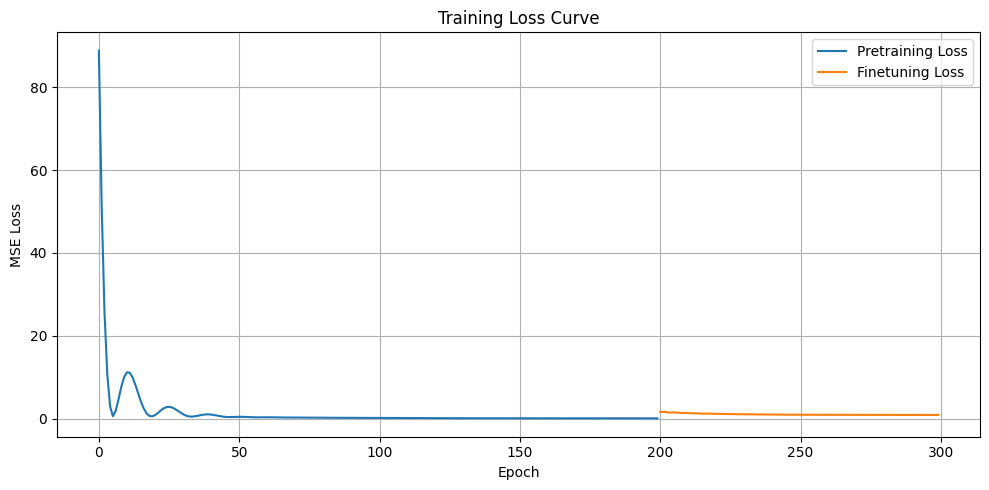

In [67]:
# ✅ 학습 곡선 시각화
plt.figure(figsize=(10, 5))
plt.plot(pretrain_losses, label="Pretraining Loss")
plt.plot(range(200, 200 + len(finetune_losses)), finetune_losses, label="Finetuning Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [68]:
print(df_finetune["Rigorous_CAPEX"].describe())


count    200.00000
mean       2.17920
std        1.98196
min        0.84010
25%        1.34850
50%        1.70235
75%        2.33840
max       23.60450
Name: Rigorous_CAPEX, dtype: float64


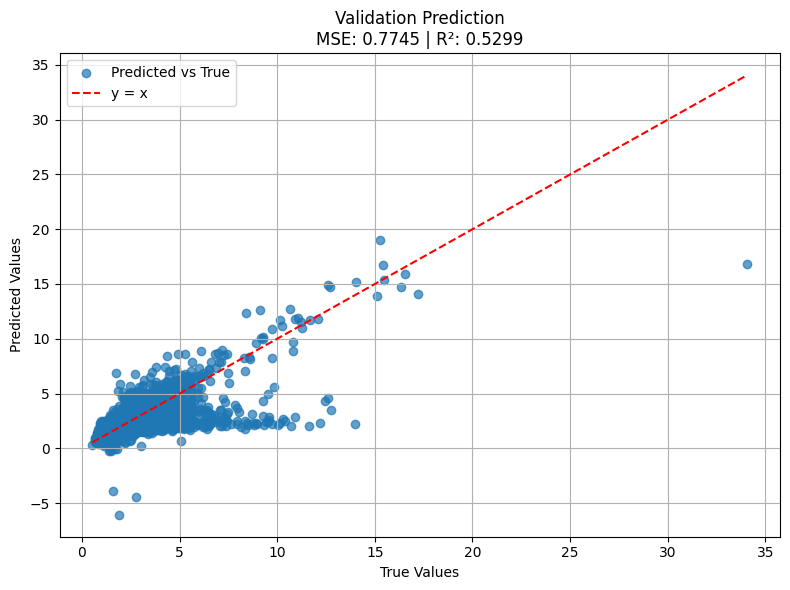

In [69]:
# ✅ 검증 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.7, label='Predicted vs True')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='y = x')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"Validation Prediction\nMSE: {mse:.4f} | R²: {r2:.4f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
